In [108]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')

In [109]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# zufällige negative Stichproben ziehen (gleiche Anzahl wie positive Fälle)
not_depressed_sample = not_depressed.sample(n=len(depressed), random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])

x = balanced_dataset.loc[:, 'Age':'Stress_Level']
y = balanced_dataset['Depression']

In [110]:
import torch

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, TargetEncoder
from torch.utils.data import TensorDataset, DataLoader

# Seed für Reproduzierbarkeit setzen
torch.manual_seed(42)
generator = torch.Generator().manual_seed(42) # für DataLoader-Shuffling

# Aufteilen in Training, Validierung und Test (60% Train, 20% Val, 20% Test)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Spalten nach Typ trennen
target_encode_cols = ['Department']
onehot_cols = [c for c in x.select_dtypes(include='category').columns if c not in target_encode_cols]
numeric_cols = x.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder, TargetEncoding für Department)
preprocessor = ColumnTransformer([
    ("numeric",     RobustScaler(),                           numeric_cols),
    ("onehot",      OneHotEncoder(drop='first', sparse_output=False), onehot_cols),
    ("target_enc",  TargetEncoder(target_type='binary', smooth='auto'), target_encode_cols),
])

# Fit-Transform auf Trainingsdaten, Transform auf Val-/Testdaten
x_train_scaled = preprocessor.fit_transform(x_train, y_train)
x_val_scaled = preprocessor.transform(x_val)
x_test_scaled = preprocessor.transform(x_test)

# setzen der neuen Feature-Anzahl nach Preprocessing
input_dim = x_train_scaled.shape[1]
output_dim = 1 # binäre Klassifikation (Depression ja/nein)


batch_size = 128
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train_scaled), torch.FloatTensor(y_train.values).view(-1, 1)), batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val_scaled), torch.FloatTensor(y_val.values).view(-1, 1)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test_scaled), torch.FloatTensor(y_test.values).view(-1, 1)), batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 95
Validation batches: 32
Test batches: 32


/\ Allgemeiner Code

\\/ Modelle definieren und Grundlage für Training legen

In [111]:
import torch.nn as nn

class FlexibleClassifier(nn.Module):
    """
    Flexible neural network that can be configured with different architectures.
    Supports variable depth and layer dimensions.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer dimensions, e.g., [64, 32]
            output_dim: Number of output classes
            dropout_rate: Dropout probability
        """
        super().__init__()
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim)) # Normalisierungsschicht hinzugefügt
            layers.append(nn.LeakyReLU(0.1)) # LeakyReLU anstelle von ReLU 
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [112]:
import torch.nn.functional as F

class FunnelNetwork(nn.Module):
    """
    Funnel architecture: Wide → Narrow
    Starts with many neurons and gradually reduces.
    Good for learning broad features then focusing.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 128 → 64 → 32 (funnel shape)
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [113]:
class InvertedFunnelNetwork(nn.Module):
    """
    Inverted Funnel architecture: Narrow → Wide
    Starts focused and gradually expands representation.
    Builds increasingly complex features.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 32 → 64 → 128 (inverted funnel shape)
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [114]:
class BrickNetwork(nn.Module):
    """
    Brick architecture: Constant width
    All hidden layers have the same number of neurons.
    Good for maintaining consistent representation.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 64 → 64 → 64 (brick/constant shape)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [115]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * batch_X.size(0)
        # Vorhersagen in binäre Klassen umwandeln (Schwellenwert 0.5) - wird benötigt wegen BCEWithLogitsLoss
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            eval_loss += loss.item() * batch_X.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

/\ Modelle definieren und Grundlage für Training legen

\\/ Spezifischer Code für das Ensemble Learning

In [116]:
def train_model(model, train_loader, val_loader, num_epochs=150, weight_decay=1e-4, lr=0.01):
    """Train a single model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion=nn.BCEWithLogitsLoss()
    
    best_val_acc = 0.0
    patience = 20
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_acc

In [ ]:
# Laden des besten Modells aus der Hyperparameter-Optimierung
checkpoint = torch.load("best_optuna_model.pt")

params = checkpoint["params"]

hidden_dims = [
    params[f"hidden_dim_layer_{i}"]
    for i in range(params["n_layers"])
]

best_optuna_model = FlexibleClassifier(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=1,
    dropout_rate=params["dropout_rate"]
)

best_optuna_model.load_state_dict(checkpoint["model_state_dict"])
best_optuna_model.eval()

print("Loaded Best Model Accuracy:", checkpoint["val_acc"])

Loaded Best Model Accuracy: 0.6857142857142857


In [ ]:
models = {
    "FunnelNetwork": FunnelNetwork(input_dim=input_dim, output_dim=output_dim),
    "Inverted FunnelNetwork": InvertedFunnelNetwork(input_dim=input_dim, output_dim=output_dim),
    "BrickNetwork": BrickNetwork(input_dim=input_dim, output_dim=output_dim)
}

# Trainiere und evaluiere jedes Modell
for name, model in models.items():
    best_val_acc = train_model(model, train_loader, val_loader, weight_decay=1e-4, lr=0.01)
    print(f"{name} with Validation Accuracy of: {best_val_acc:.4f}")

# Hinzufügen des bereits trainierten Optuna-Modells zur Vergleichsliste
models["Optuna Model"] = best_optuna_model

FunnelNetwork with Validation Accuracy of: 0.6852
Inverted FunnelNetwork with Validation Accuracy of: 0.6865
BrickNetwork with Validation Accuracy of: 0.6877


In [ ]:
import numpy as np

def predict_majority_voting(models, X):
    """
    Hard majority voting: Each model votes for a class, majority wins.
    """
    votes = []
    
    # Votes von jedem Modell sammeln
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(X)
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            votes.append(predicted.numpy())
    
    # votes shape: (n_models, n_samples)
    votes = np.array(votes)
    
    # Durchschnittliche Wahrscheinlichkeit über alle Modelle berechnen
    mean_probs = votes.mean(axis=0)  # shape: (n_samples,)
    
    # Grenze bei 0.5: Wenn mehr als die Hälfte der Modelle für Klasse 1 stimmt, dann Vorhersage 1, sonst 0
    ensemble_predictions = (mean_probs > 0.5).astype(int)
    
    return np.array(ensemble_predictions)

/\ Spezifischer Code für das Ensemble Learning

\\/ Auswertung

              precision    recall  f1-score   support

       False       0.67      0.74      0.70      2013
        True       0.71      0.63      0.67      2012

    accuracy                           0.69      4025
   macro avg       0.69      0.69      0.69      4025
weighted avg       0.69      0.69      0.69      4025



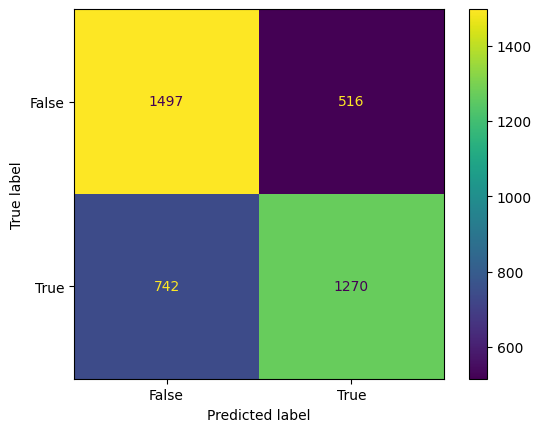

In [123]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = predict_majority_voting(models.values(), torch.FloatTensor(x_test_scaled))

print(classification_report(y_test, y_pred, target_names=sorted(y_test.unique().astype(str))))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=sorted(y_test.unique().astype(str)))